In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

In [2]:
root = "/cluster/projects/p33/users/alexeas/elleke/pleioprs"
noda_export = os.path.join(root, "pheno", "noda_query_2021-12-03_13.02_8fd09a4.csv")
df = pd.read_csv(noda_export, sep=';')
print(df.shape)
df.head()

(9911, 100)


,subjid,project,cohort,subcohort,diagnosis,subdiagnosis,sex,yearofbirth,ageatinc,ethnicity,...,neo_neo_55,neo_neo_56,neo_neo_57,neo_neo_58,neo_neo_59,neo_neo_60,neo_kommentarneo,iqtwotest_sessionnk,iqtwotest_datenk,iqtwotest_iqwasi_2test
0,1-007-1,Bergen_BP,bergen_bp,psychiatric_cohorts,other,Psykiske lidelser og atferdsforstyrrelser som ...,male,1989.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1-007-4,Bergen_BP,bergen_bp,psychiatric_cohorts,BD,"Bipolar affektiv lidelse, i remisjon",female,1957.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1-008-1,Bergen_BP,bergen_bp,psychiatric_cohorts,PSY,"Akutt forbigaende psykose, uspesifisert",male,1989.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1-009-1,Bergen_BP,bergen_bp,psychiatric_cohorts,SCZ,Udifferensiert schizofreni,female,1994.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1-009-4,Bergen_BP,bergen_bp,psychiatric_cohorts,BD,"Bipolar affektiv lidelse, aktuell episode blandet",male,1967.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.diagnosis.value_counts()

SCZ              1531
BD               1464
CTRL             1452
stroke           1217
MISSING           992
AUT               671
PSY               514
DEP               396
control           249
SUBSTANCE         158
DEV               146
ID NOT IN USE     141
EXCLUDED          141
ANX               116
PERSON             84
RARE               58
MOOD               55
INT                36
other              32
OTHER              29
ORGANIC            22
MOTOR              17
NO DIAGNOSIS       11
EATING             10
SOMATIC             3
ADHD                3
SOMA                1
OCD                 1
DEM                 1
SZ                  1
AFF                 1
Name: diagnosis, dtype: int64

In [9]:
# Keep only relevant columns
# Keep Europeans only
# Drop subjects with any NA data
# Drop duplicated subjects
# Standardize diagnosis, sex
cols2keep = ['subjid', 'genetics_uid', 'diagnosis', 'sex', 'ageatinc'] + [f"genetics_pc{i}" for i in range(1,11)]
diag2keep = ["SCZ", "SZ", "BD", "DEP", "AUT", "CTRL", "control"]
ethnicity2keep = ['European (caucasian)']
df = df.loc[df.diagnosis.isin(diag2keep) & df.ethnicity.isin(ethnicity2keep), cols2keep]
df = df.loc[df.notna().all(axis=1),:]
df.drop_duplicates(subset='subjid', inplace=True, ignore_index=True)
df.sex.replace({"male":1,"female":0}, inplace=True)

df.diagnosis.replace("SZ", "SCZ", inplace=True)
df.diagnosis.replace("BD", "BIP", inplace=True)
df.diagnosis.replace("control", "CTRL", inplace=True)

for dx in ["SCZ", "BIP", "DEP", "AUT"]:
    df[dx] = "NA"
    df.loc[df.diagnosis=="CTRL", dx] = 1
    df.loc[df.diagnosis==dx, dx] = 2

df["FID"] = df.genetics_uid
df["IID"] = df.genetics_uid

df.rename(columns={f"genetics_pc{i}":f"PC{i}" for i in range(1,11)}, inplace=True)
df.rename(columns={"sex":"SEX", "ageatinc":"AGE"}, inplace=True)

print(df.shape)
df.head()

(2737, 21)


,subjid,genetics_uid,diagnosis,SEX,AGE,PC1,PC2,PC3,PC4,PC5,...,PC7,PC8,PC9,PC10,SCZ,BIP,DEP,AUT,FID,IID
0,A1004,PACBUWY_A1004,SCZ,1,19.0,-0.002183,-0.002230,-0.003249,-0.003816,0.001370,...,-0.004657,-0.001271,-0.000259,0.003481,2,NA,NA,NA,PACBUWY_A1004,PACBUWY_A1004
1,A1010,PACIREY_A1010,SCZ,0,27.0,0.000265,-0.000741,-0.001900,-0.000583,-0.002011,...,-0.004485,0.008841,-0.005596,0.000968,2,NA,NA,NA,PACIREY_A1010,PACIREY_A1010
2,A1012,PACBVRW_A1012,SCZ,1,31.0,0.003893,-0.001681,-0.000331,-0.002033,-0.001950,...,0.001577,-0.001018,-0.000109,-0.003981,2,NA,NA,NA,PACBVRW_A1012,PACBVRW_A1012
3,A1015,PACCPHS_A1015,SCZ,0,27.0,0.000167,-0.006623,-0.001647,-0.000771,-0.003106,...,-0.001550,-0.003410,-0.004039,-0.000766,2,NA,NA,NA,PACCPHS_A1015,PACCPHS_A1015
4,A1016,PACBUQH_A1016,SCZ,0,32.0,-0.000501,-0.004251,-0.000632,-0.002569,-0.002323,...,0.000471,-0.002118,0.002766,0.002900,2,NA,NA,NA,PACBUQH_A1016,PACBUQH_A1016


In [5]:
df.diagnosis.value_counts()

CTRL    1073
SCZ      735
BIP      463
AUT      331
DEP      135
Name: diagnosis, dtype: int64

In [10]:
# save pheno and covar
covar_fname = os.path.join(root, "pheno", "covar.txt")
covar_cols = ["FID", "IID", "SEX", "AGE"] + [f"PC{i}" for i in range(1,11)]
df_covar = df[covar_cols]

pheno_fname = os.path.join(root, "pheno", "pheno.txt")
pheno_cols = ["FID", "IID", "SCZ", "BIP", "AUT", "DEP"]
df_pheno = df[pheno_cols]

df_covar.to_csv(covar_fname, sep='\t', index=False)
df_pheno.to_csv(pheno_fname, sep='\t', index=False)


In [4]:
# allign variant IDs between sumstats and geno bim file

def allign_sumstats_to_bim(sumstats_fname, bim_fname):
    bim_ids = pd.read_table(bim_fname, header=None, usecols=[1], names=["SNP"]).squeeze()
    df_sumstats = pd.read_table(sumstats_fname)
    print(f"{df_sumstats.shape[0]} variants in {sumstats_fname}")
    complementary_dict = {"A":"T", "G":"C", "T":"A", "C":"G"}
    reverse_coplement = lambda seq: ''.join([complementary_dict.get(b,b) for b in seq[::-1]]) 
    chr_bp = df_sumstats.CHR.map(str) + ":" + df_sumstats.BP.map(str)
    ids_a1_a2 = chr_bp + ":" + df_sumstats.A1 + ":" + df_sumstats.A2
    ids_a2_a1 = chr_bp + ":" + df_sumstats.A2 + ":" + df_sumstats.A1
    a1_comp = df_sumstats.A1.apply(reverse_coplement)
    a2_comp = df_sumstats.A2.apply(reverse_coplement)
    ids_a1_a2_comp = chr_bp + ":" + a1_comp + ":" + a2_comp
    ids_a2_a1_comp = chr_bp + ":" + a2_comp + ":" + a1_comp
    
    df_sumstats["ID"] = ids_a1_a2
    print(f"{ids_a1_a2.isin(bim_ids).sum()} variant ids alligned based on a1-a2")
    i_a2_a1 = ids_a2_a1.isin(bim_ids)
    print(f"{i_a2_a1.sum()} variant ids alligned based on a2-a1")
    df_sumstats.loc[i_a2_a1, "ID"] = ids_a2_a1[i_a2_a1]
    i_a1_a2_comp = ids_a1_a2_comp.isin(bim_ids)
    print(f"{i_a1_a2_comp.sum()} variant ids alligned based on a1c-a2c")
    df_sumstats.loc[i_a1_a2_comp, "ID"] = ids_a1_a2_comp[i_a1_a2_comp]
    i_a2_a1_comp = ids_a2_a1_comp.isin(bim_ids)
    print(f"{i_a2_a1_comp.sum()} variant ids alligned based on a2c-a1c")
    df_sumstats.loc[i_a2_a1_comp, "ID"] = ids_a2_a1_comp[i_a2_a1_comp]
    is_in_geno = df_sumstats.ID.isin(bim_ids)
    i_no_dup = ~df_sumstats.ID.duplicated()
    df_sumstats = df_sumstats.loc[i_no_dup & is_in_geno,:]
    print(f"{df_sumstats.shape[0]} variants remain after aligning to {bim_fname}")
    return df_sumstats

if False:
    bim_fname = os.path.join(root, "geno", "all_qc.bim")
    sumstats_fname = os.path.join(root, "sumstats", "SCZ.sumstats.prs.txt")
    df_sumstats = allign_sumstats_to_bim(sumstats_fname, bim_fname)
    outf = os.path.join(root, "sumstats", "SCZ.sumstats.prs.id.txt")
    df_sumstats.to_csv(outf, sep='\t', index=False)

    sumstats_fname = os.path.join(root, "sumstats", "BIP.sumstats.prs.txt")
    df_sumstats = allign_sumstats_to_bim(sumstats_fname, bim_fname)
    outf = os.path.join(root, "sumstats", "BIP.sumstats.prs.id.txt")
    df_sumstats.to_csv(outf, sep='\t', index=False)
    
bim_fname = os.path.join(root, "geno", "all_qc.bim")
sumstats_fname = os.path.join(root, "sumstats", "ADHD.sumstats.prs.txt")
df_sumstats = allign_sumstats_to_bim(sumstats_fname, bim_fname)
outf = os.path.join(root, "sumstats", "ADHD.sumstats.prs.id.txt")
df_sumstats.to_csv(outf, sep='\t', index=False)

5747605 variants in /cluster/projects/p33/users/alexeas/elleke/pleioprs/sumstats/ADHD.sumstats.prs.txt
2210121 variant ids alligned based on a1-a2
2623839 variant ids alligned based on a2-a1
0 variant ids alligned based on a1c-a2c
0 variant ids alligned based on a2c-a1c
4833960 variants remain after aligning to /cluster/projects/p33/users/alexeas/elleke/pleioprs/geno/all_qc.bim


In [3]:
# Add FDR column to SCZ, BIP and HAND-GRIP sumstats
def merge_sumstats_and_fdr(sumstats_fname, fdr_fname):
    df_ss_head = pd.read_table(sumstats_fname, nrows=10)
    usecols=["SNP", "CHR", "BP", "A1", "A2", "BETA", "OR", "PVAL"]
    usecols = [col for col in usecols if col in df_ss_head.columns]
    assert ("OR" in usecols) or ("BETA" in usecols), f"Neither BETA not OR column is in {sumstats_fname}"
    if ("OR" in usecols) and ("BETA" in usecols):
        usecols.remove("OR")
    df_ss = pd.read_table(sumstats_fname, usecols=usecols)
    if ("OR" in usecols) and (not ("BETA" in usecols)):
        df_ss["BETA"] = np.log(df_ss.OR)
        df_ss.drop(columns="OR", inplace=True)
    print(f"{df_ss.shape[0]} SNPs in {sumstats_fname}")
    df_fdr = pd.read_table(fdr_fname, usecols=["SNP", "FDR"])
    df_fdr = df_fdr.loc[df_fdr.FDR.notna(),:]
    df = df_ss.merge(df_fdr, on="SNP", how='inner')
    print(f"{df.shape[0]} SNPs remains after merging")
    return df

if False:
    sumstats_fname = os.path.join(root, "sumstats", "PGC_SCZ_0518_EUR_noTOP.sumstats.gz")
    fdr_fname = os.path.join(root, "condfdr_results", "condfdr_SCZ_MOSTest-multimodal", "result.mat.csv")
    df = merge_sumstats_and_fdr(sumstats_fname, fdr_fname)
    outf = os.path.join(root, "sumstats", "SCZ.sumstats.prs.txt")
    df.to_csv(outf, sep='\t', index=False)
    print(f"{outf} saved")

    sumstats_fname = os.path.join(root, "sumstats", "PGC_BIP_2016_noTOP_qc.sumstats.gz")
    fdr_fname = os.path.join(root, "condfdr_results", "condfdr_BIP_MOSTest-multimodal", "result.mat.csv")
    df = merge_sumstats_and_fdr(sumstats_fname, fdr_fname)
    outf = os.path.join(root, "sumstats", "BIP.sumstats.prs.txt")
    df.to_csv(outf, sep='\t', index=False)
    print(f"{outf} saved")

    sumstats_fname = os.path.join(root, "sumstats", "HAND_GRIP_TOTAL_RINT.WHITE_BRITISH_SELF_GEN_NO_IMAGING_SUBSET_GWAS.covar_HEIGHT_BMI.regenie.csv")
    fdr_fname = os.path.join(root, "condfdr_results", "condfdr_HAND-GRIP_MOSTest-multimodal", "result.mat.csv")
    df = merge_sumstats_and_fdr(sumstats_fname, fdr_fname)
    outf = os.path.join(root, "sumstats", "HAND_GRIP.sumstats.prs.txt")
    df.to_csv(outf, sep='\t', index=False)
    print(f"{outf} saved")
    

sumstats_fname = os.path.join(root, "sumstats", "PGC_ADHD_2017_EUR.sumstats.gz")
fdr_fname = os.path.join(root, "condfdr_results", "condfdr_ADHD_MOSTest-multimodal", "result.mat.csv")
df = merge_sumstats_and_fdr(sumstats_fname, fdr_fname)
outf = os.path.join(root, "sumstats", "ADHD.sumstats.prs.txt")
df.to_csv(outf, sep='\t', index=False)
print(f"{outf} saved")

8094094 SNPs in /cluster/projects/p33/users/alexeas/elleke/pleioprs/sumstats/PGC_ADHD_2017_EUR.sumstats.gz
5747605 SNPs remains after merging
/cluster/projects/p33/users/alexeas/elleke/pleioprs/sumstats/ADHD.sumstats.prs.txt saved


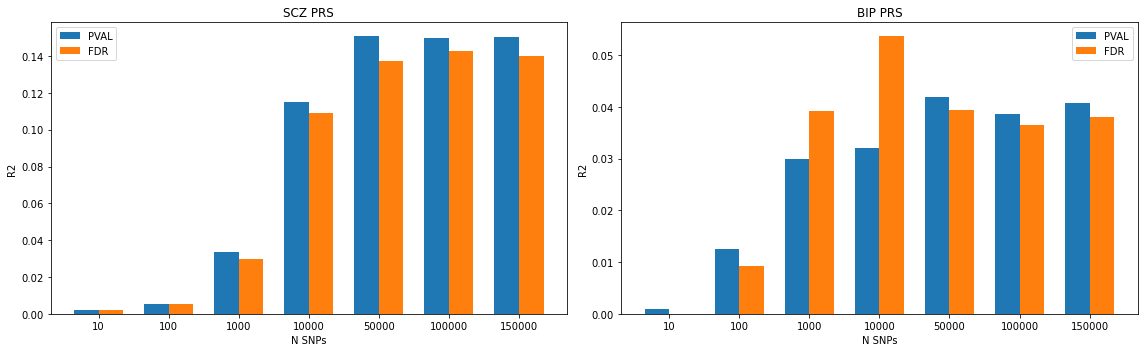

In [8]:
# plot PRS
outf="pleioPRS_SCZ_BIP_mostest.png"

n_snps = [10, 100, 1000, 10000, 50000, 100000, 150000]
r2_dict = {}
for trait in ["SCZ", "BIP"]:
    for stat in ["PVAL", "FDR"]:
        for n in n_snps:
            fname = os.path.join(root, "prs", f"{trait}.{stat}.{n}.prsice")
            df = pd.read_table(fname, delim_whitespace=True)
            r2_dict[f"{trait}_{stat}_{n}"] = df.R2[0]

            
scz_pval, scz_fdr = [], []
bip_pval, bip_fdr = [], []
for n in n_snps:
    scz_pval.append(r2_dict[f"SCZ_PVAL_{n}"])
    scz_fdr.append(r2_dict[f"SCZ_FDR_{n}"])
    bip_pval.append(r2_dict[f"BIP_PVAL_{n}"])
    bip_fdr.append(r2_dict[f"BIP_FDR_{n}"])

x = np.arange(len(scz_pval))
width = 0.35

fig, axs = plt.subplots(1,2,figsize=(16,5))

rects1 = axs[0].bar(x - width/2, scz_pval, width, label='PVAL')
rects2 = axs[0].bar(x + width/2, scz_fdr, width, label='FDR')

axs[0].set_ylabel('R2')
axs[0].set_xlabel('N SNPs')
axs[0].set_title('SCZ PRS')
axs[0].set_xticks(x, map(str, n_snps))
axs[0].legend()


rects1 = axs[1].bar(x - width/2, bip_pval, width, label='PVAL')
rects2 = axs[1].bar(x + width/2, bip_fdr, width, label='FDR')

axs[1].set_ylabel('R2')
axs[1].set_xlabel('N SNPs')
axs[1].set_title('BIP PRS')
axs[1].set_xticks(x, map(str, n_snps))
axs[1].legend()

plt.tight_layout()

plt.savefig(outf, dpi=200, facecolor='w')

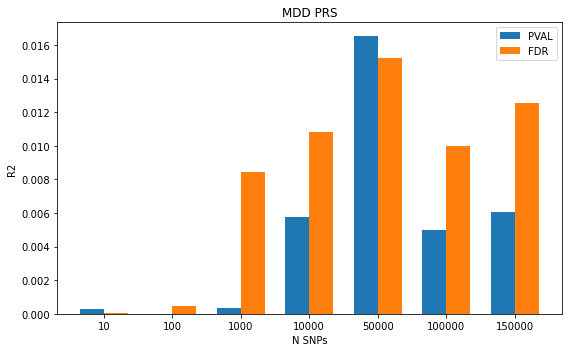

In [8]:
# plot PRS
outf="pleioPRS_MDD_mostest.png"
savefig = True

n_snps = [10, 100, 1000, 10000, 50000, 100000, 150000]
r2_dict = {}
for trait in ["MDD"]:
    for stat in ["PVAL", "FDR"]:
        for n in n_snps:
            fname = os.path.join(root, "prs", f"{trait}.{stat}.{n}.prsice")
            df = pd.read_table(fname, delim_whitespace=True)
            r2_dict[f"{trait}_{stat}_{n}"] = df.R2[0]

            
scz_pval, scz_fdr = [], []
bip_pval, bip_fdr = [], []
for n in n_snps:
    scz_pval.append(r2_dict[f"MDD_PVAL_{n}"])
    scz_fdr.append(r2_dict[f"MDD_FDR_{n}"])

x = np.arange(len(scz_pval))
width = 0.35

fig, ax = plt.subplots(1,1,figsize=(8,5))

rects1 = ax.bar(x - width/2, scz_pval, width, label='PVAL')
rects2 = ax.bar(x + width/2, scz_fdr, width, label='FDR')

ax.set_ylabel('R2')
ax.set_xlabel('N SNPs')
ax.set_title('MDD PRS')
ax.set_xticks(x, map(str, n_snps))
ax.legend()

plt.tight_layout()
if savefig:
    plt.savefig(outf, dpi=200, facecolor='w')

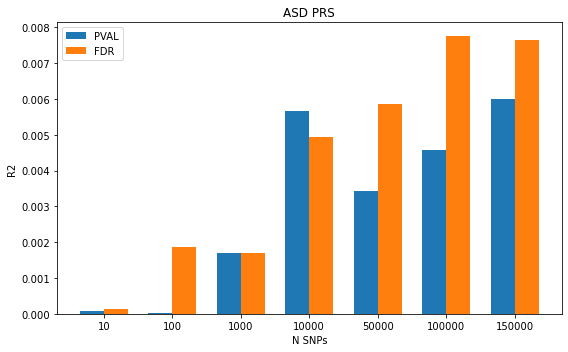

In [10]:
# plot PRS
outf="pleioPRS_ASD_mostest.png"
savefig = True

n_snps = [10, 100, 1000, 10000, 50000, 100000, 150000]
r2_dict = {}
for trait in ["ASD"]:
    for stat in ["PVAL", "FDR"]:
        for n in n_snps:
            fname = os.path.join(root, "prs", f"{trait}.{stat}.{n}.prsice")
            df = pd.read_table(fname, delim_whitespace=True)
            r2_dict[f"{trait}_{stat}_{n}"] = df.R2[0]

            
scz_pval, scz_fdr = [], []
bip_pval, bip_fdr = [], []
for n in n_snps:
    scz_pval.append(r2_dict[f"ASD_PVAL_{n}"])
    scz_fdr.append(r2_dict[f"ASD_FDR_{n}"])

x = np.arange(len(scz_pval))
width = 0.35

fig, ax = plt.subplots(1,1,figsize=(8,5))

rects1 = ax.bar(x - width/2, scz_pval, width, label='PVAL')
rects2 = ax.bar(x + width/2, scz_fdr, width, label='FDR')

ax.set_ylabel('R2')
ax.set_xlabel('N SNPs')
ax.set_title('ASD PRS')
ax.set_xticks(x, map(str, n_snps))
ax.legend()

plt.tight_layout()
if savefig:
    plt.savefig(outf, dpi=200, facecolor='w')